In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapley_sampling import SamplingExplainerTF
from path_explain import utils, scatter_plot, summary_plot

In [4]:
utils.set_up_environment(visible_devices='0')

In [5]:
n = 5000
d = 5
noise = 0.5
X = np.random.randn(n, d)
y = np.sum(X, axis=-1) + 2 * np.prod(X[:, 0:2], axis=-1)

In [6]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=10,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=5,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [9]:
learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [10]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 799 samples, validate on 3201 samples
Epoch 1/20
799/799 - 1s - loss: 7.8435 - val_loss: 7.2729
Epoch 2/20
799/799 - 0s - loss: 3.4170 - val_loss: 2.9626
Epoch 3/20
799/799 - 0s - loss: 2.0688 - val_loss: 2.0264
Epoch 4/20
799/799 - 0s - loss: 1.2352 - val_loss: 1.0227
Epoch 5/20
799/799 - 0s - loss: 1.5483 - val_loss: 0.7229
Epoch 6/20
799/799 - 0s - loss: 0.4475 - val_loss: 0.5913
Epoch 7/20
799/799 - 0s - loss: 0.6002 - val_loss: 0.4498
Epoch 8/20
799/799 - 0s - loss: 0.4499 - val_loss: 0.3112
Epoch 9/20
799/799 - 0s - loss: 0.2775 - val_loss: 0.2253
Epoch 10/20
799/799 - 0s - loss: 0.2795 - val_loss: 0.2627
Epoch 11/20
799/799 - 0s - loss: 0.7602 - val_loss: 0.3870
Epoch 12/20
799/799 - 0s - loss: 0.5770 - val_loss: 1.0771
Epoch 13/20
799/799 - 0s - loss: 0.3333 - val_loss: 0.1932
Epoch 14/20
799/799 - 0s - loss: 0.1466 - val_loss: 0.1798
Epoch 15/20
799/799 - 0s - loss: 0.2359 - val_loss: 0.7503
Epoch 16/20
799/799 - 0s - loss: 0.4654 - val_loss: 0.2536
Epoch 17/20
799/79

In [11]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

1000/1000 - 0s - loss: 0.1412


0.14115616530179978

In [12]:
y_test_pred = model.predict(X_test, batch_size=50)

In [13]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})

In [14]:
def scatterplot(x, y, df, title=None):
    fig = plt.figure(dpi=100)
    ax = fig.gca()
    ax.scatter(df[x],
               df[y],
               s=10)
    ax.grid(linestyle='--')
    ax.set_axisbelow(True)
    ax.set_xlabel(x, fontsize=11)
    ax.set_ylabel(y, fontsize=11)
    ax.spines['top'].set_linewidth(0.1)
    ax.spines['right'].set_linewidth(0.1)
    ax.set_title(title)

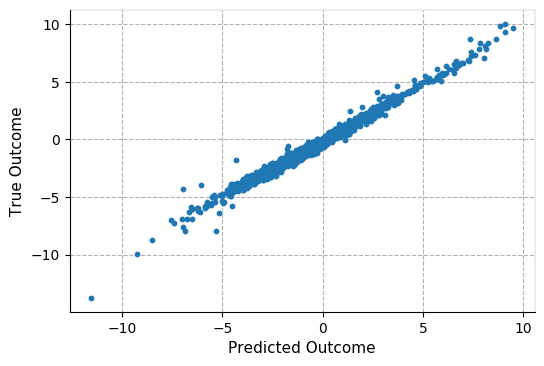

In [15]:
scatterplot('Predicted Outcome', 'True Outcome', df)

In [16]:
explainer = SamplingExplainerTF(model)

In [17]:
feature_values = X_test

In [18]:
feature_values.shape

(1000, 5)

In [43]:
feature_values[0]

array([-0.82212177,  1.71613381, -0.5659349 , -0.07800833,  0.2233887 ])

In [59]:
explainer._batch_attributions(feature_values[0:1],
                              np.zeros((1, 5)),
                              number_of_samples=None,
                              output_index=None)

array([[-2.08200821,  0.20333135, -0.53222092, -0.07713895,  0.2236181 ]])

In [71]:
model(feature_values[0:1])[0, 0] - model(np.zeros((1, 5)))[0, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=-2.2644186>

In [69]:
explainer._batch_interactions(feature_values[0:1],
                              np.zeros((1, 5)),
                              number_of_samples=None,
                              output_index=None)

array([[[ 0.00000000e+00, -3.11251849e+00, -2.91587168e-03,
         -3.82170831e-03,  8.51659244e-03],
        [-3.11251849e+00,  0.00000000e+00, -6.75136477e-02,
         -1.02877692e-02,  3.77121624e-02],
        [-2.91587168e-03, -6.75136477e-02,  0.00000000e+00,
          1.99058406e-03, -4.19342273e-03],
        [-3.82170831e-03, -1.02877692e-02,  1.99058406e-03,
          0.00000000e+00, -6.74329703e-04],
        [ 8.51659244e-03,  3.77121624e-02, -4.19342273e-03,
         -6.74329703e-04,  0.00000000e+00]]])

In [72]:
attributions = explainer.attributions(inputs=feature_values.astype(np.float32),
                                      baselines=np.zeros(5),
                                      batch_size=50,
                                      number_of_samples=None,
                                      output_index=None,
                                      verbose=False)

In [73]:
interactions = explainer.interactions(inputs=feature_values.astype(np.float32),
                                      baselines=np.zeros(5),
                                      batch_size=50,
                                      number_of_samples=None,
                                      output_index=None,
                                      verbose=False)

In [82]:
data_df = pd.DataFrame({
    'Product': 2 * np.prod(feature_values[:, 0:2], axis=-1),
    'Interaction': interactions[:, 0, 1]
})

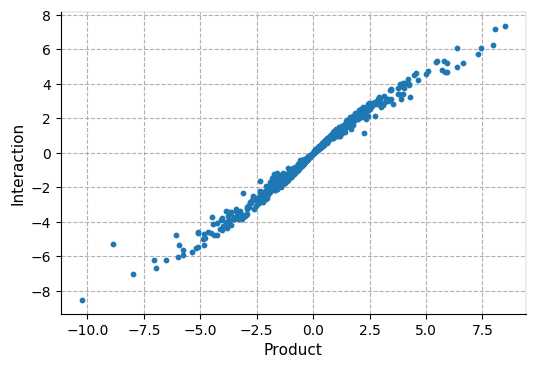

In [83]:
scatterplot('Product', 'Interaction', data_df)

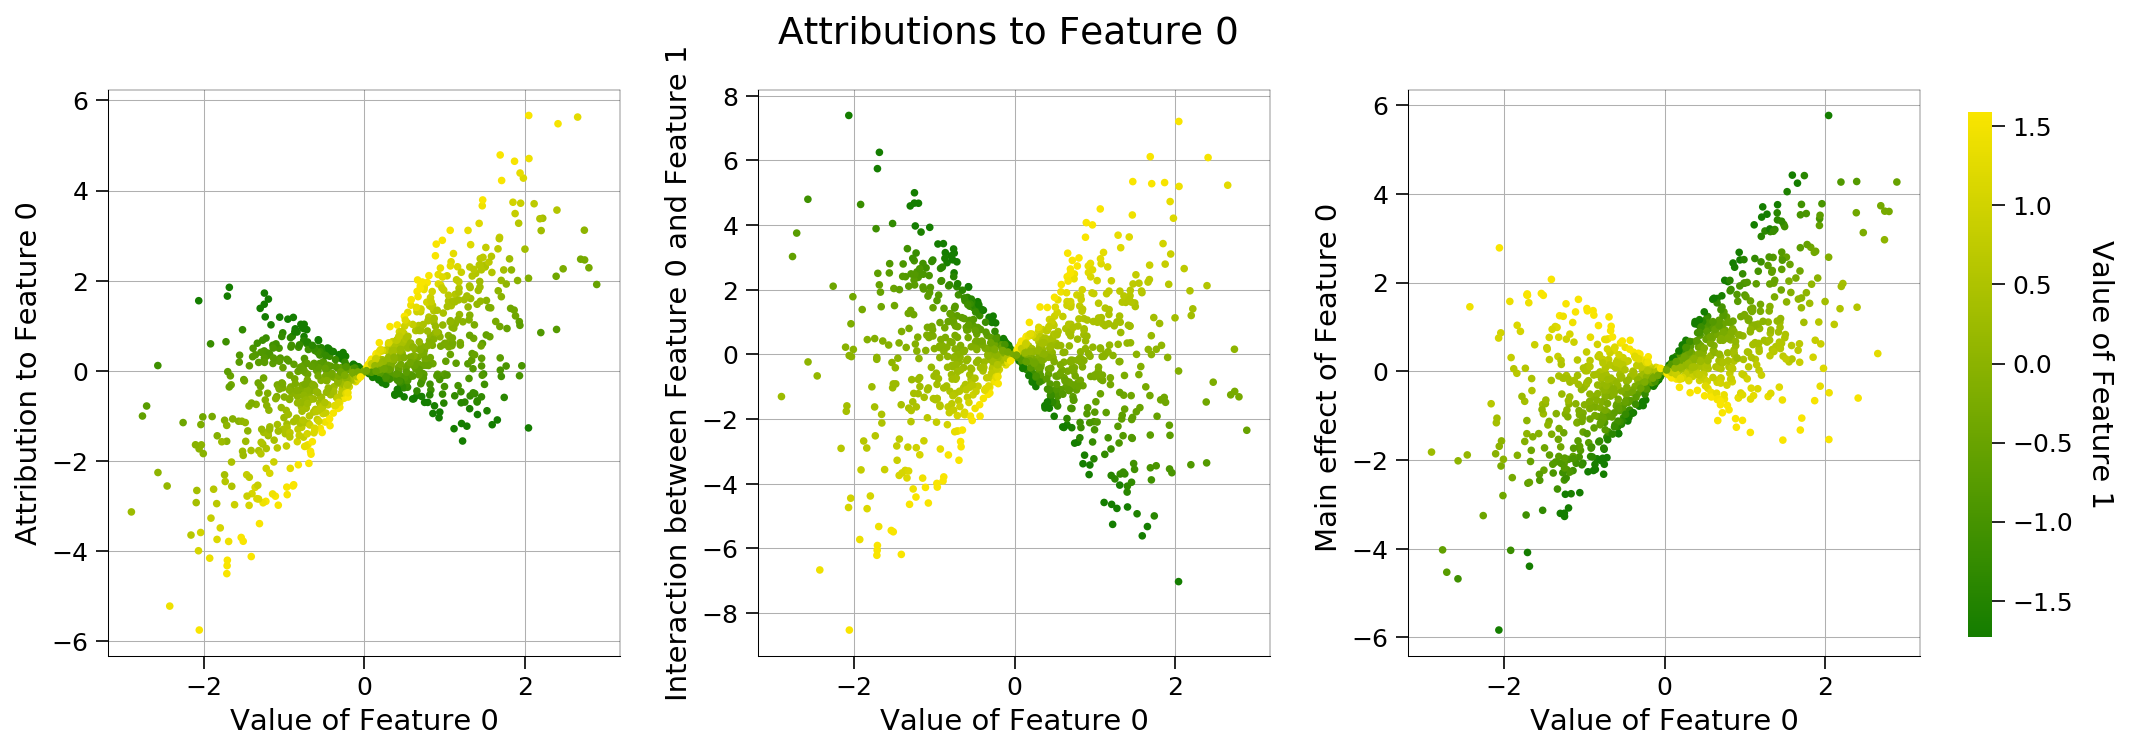

In [84]:
fig, axs = scatter_plot(attributions,
                        feature_values,
                        feature_index=0,
                        interactions=interactions * 0.5,
                        color_by=1,
                        feature_names=None,
                        scale_y_ind=True)

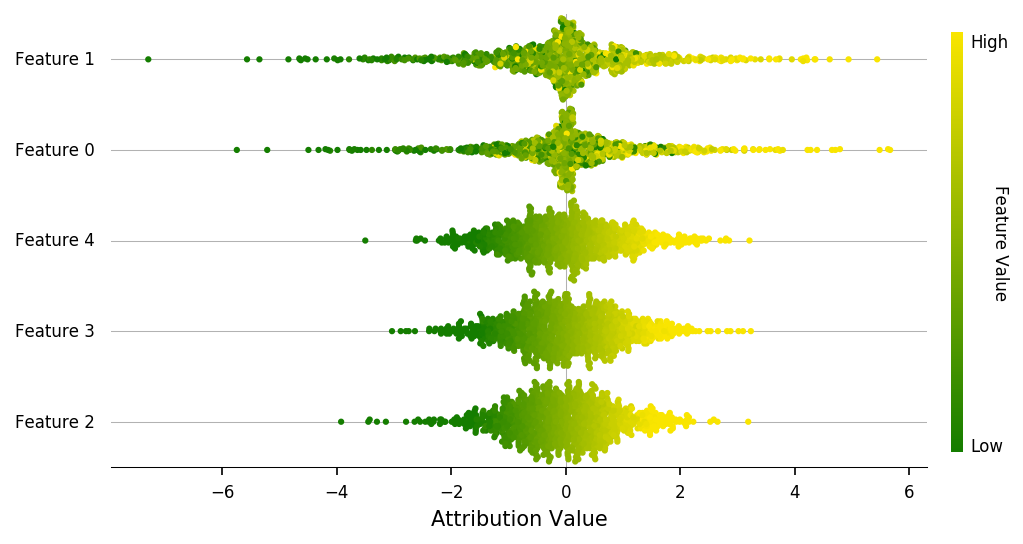

In [85]:
summary_plot(attributions,
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)

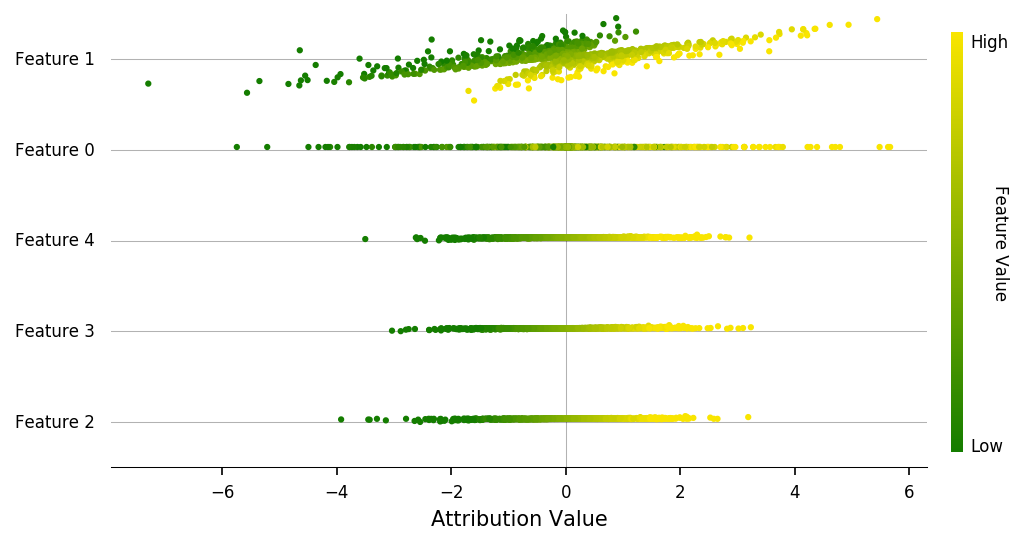

In [86]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)